In [5]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
#sys.path.append(os.path.abspath(".."))
#from src.utils import plot_neighbors, pca_binary, plot_pca_scale, plot_dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from random import sample
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.patches import Patch
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from beautifultable import BeautifulTable
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from umap import UMAP

import sys, os
project_root = os.path.abspath("..")  # relative to /nbs/

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.analyses_utils import WindowedRollingDistance, calc_vector_histogram
from scipy.ndimage import gaussian_filter1d

# we get a lot of annoying warnings from sklearn so we suppress them
import warnings
warnings.filterwarnings('ignore')

In [56]:
# default dpi
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 14,
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'axes.linewidth': 1,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

In [105]:
# update diachronic change plots
from src.analyses_utils import run_change_analysis 

def plot_diachronic_change(w_size, df, canon_col, embedding_col, cosim_to_plot, ax, step_size=1, year_col='start_year', n_runs=1, sampling=False, sample_size=0, simulate=False, num_simulations=0, sim_type='none', cutoff=5, color='C0'):

    # get dataframe of cosine similarity for each time window for chosen canon measure 
    sim_df = run_change_analysis(
                w_size,
                df,
                canon_col,
                embedding_col,
                step_size=step_size,
                year_col=year_col,
                n_runs=n_runs,
                sampling=sampling,
                sample_size=sample_size,
                simulate=simulate,
                num_simulations=num_simulations,
                sim_type=sim_type
    )

    min_group_idx = int(sim_df['n_paintings'].explode().idxmin())
    min_group_size = min(sim_df['n_paintings'].iloc[min_group_idx])
    
    # get correlation between year and cosine similarity
    corr, pval = spearmanr(sim_df['START_year'], sim_df[cosim_to_plot])

    # plot change over time
    ax.plot(sim_df['START_year'], sim_df[cosim_to_plot], color=color, linewidth=3, alpha=1)

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

    if pval < 0.01:
        greater_dir = '<'
    else:
        greater_dir = '>'

    col_or_grey = 'colored' if embedding_col == 'embedding' else 'greyscaled'

    title_mapping = {'exb_canon': 'Exhibitions canon',
                     'smk_exhibitions': 'SMK exhibitions canon',
                     'on_display': 'On display canon'}

    ylabel = 'Mean Cosine Similarity'

    if cosim_to_plot == 'CANON_NONCANON_COSIM':
        ax.set_title(f"{title_mapping[canon_col]} ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1")
        ylabel = 'Cosine Similarity'

    elif cosim_to_plot == 'TOTAL_COSIM_MEAN':
        ax.set_title(f'Total data ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1')

    else:
        ax.set_title(f'{title_mapping[canon_col]} ({col_or_grey})\n$r$ = {corr:.2f}, p {greater_dir} 0.1')

    # create plot
    ax.set_xlabel('t')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', length=4, width=1)

In [106]:
def plot_grid(df, color_subset, canon_cols, w_size, cosim_to_plot, title, savefig, filename):

    fig, axs = plt.subplots(2, 3, figsize=(17, 10))

    for idx, col in enumerate(canon_cols):

        plot_diachronic_change(w_size = 30, 
                            df = color_subset, 
                            canon_col = col, 
                            embedding_col = 'embedding', 
                            cosim_to_plot = cosim_to_plot, 
                            ax = axs[0, idx])
        
        plot_diachronic_change(w_size = 30, 
                            df = df, 
                            canon_col = col, 
                            embedding_col = 'grey_embedding', 
                            cosim_to_plot = cosim_to_plot, 
                            ax = axs[1, idx])

        if idx != 0:
            axs[0, idx].set_ylabel('')   # Remove Y label
            axs[1, idx].set_ylabel('') 
            
        if savefig:
            plt.savefig(filename, format='pdf', bbox_inches='tight')
    
    fig.tight_layout()

In [27]:
df = pd.read_pickle(os.path.join('..', 'data', 'df_new_prod_years.pkl'))
ds = datasets.load_from_disk(os.path.join('..', 'data', 'smk_only_paintings_NEW_DATES'))

In [28]:
# make subset of colored images only 
color_subset = df.query('rgb == "color"')
color_idx = color_subset.index.tolist()
ds_color = ds.select(color_idx)
color_subset.reset_index(drop=True, inplace=True)

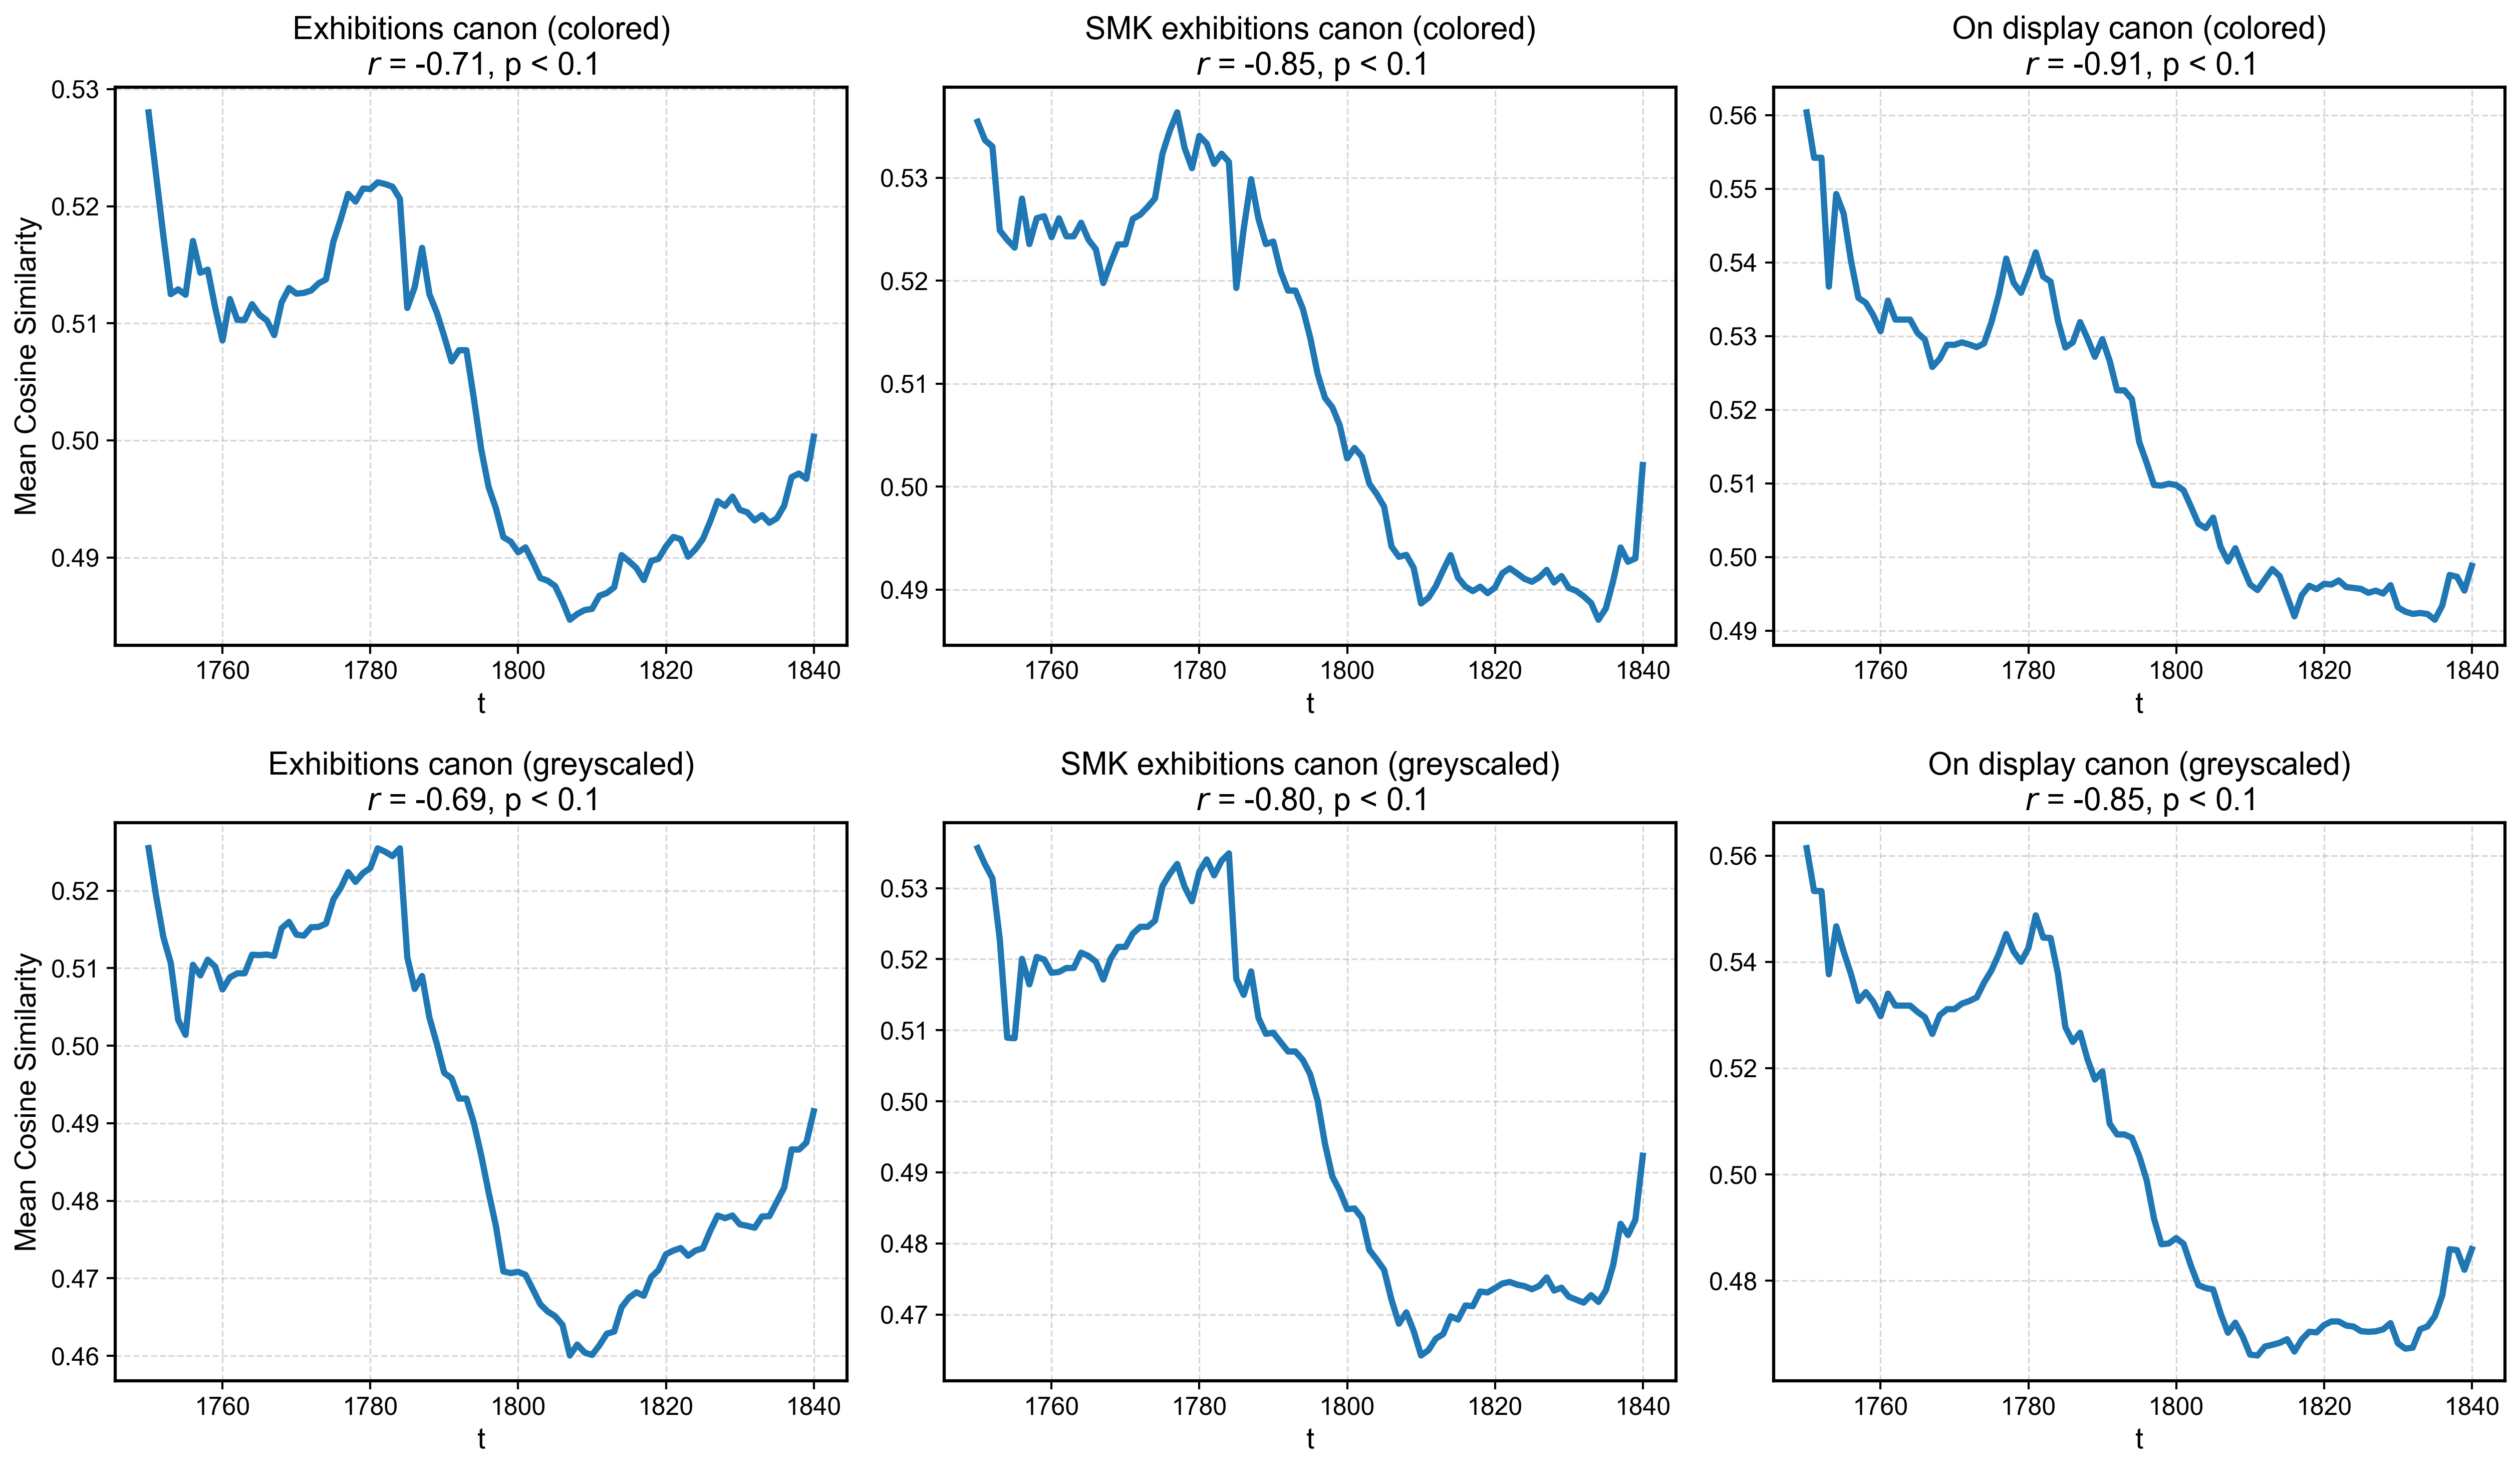

In [107]:
# canon

canon_cols = ['exb_canon', 'smk_exhibitions', 'on_display']
plot_grid(df = df,
           color_subset=color_subset, 
            canon_cols = canon_cols,
            w_size= 30, 
            cosim_to_plot='CANON_COSIM_MEAN', 
            title='', 
            savefig=False,
            filename=os.path.join('figs', f'intra_canon_w30.png'))

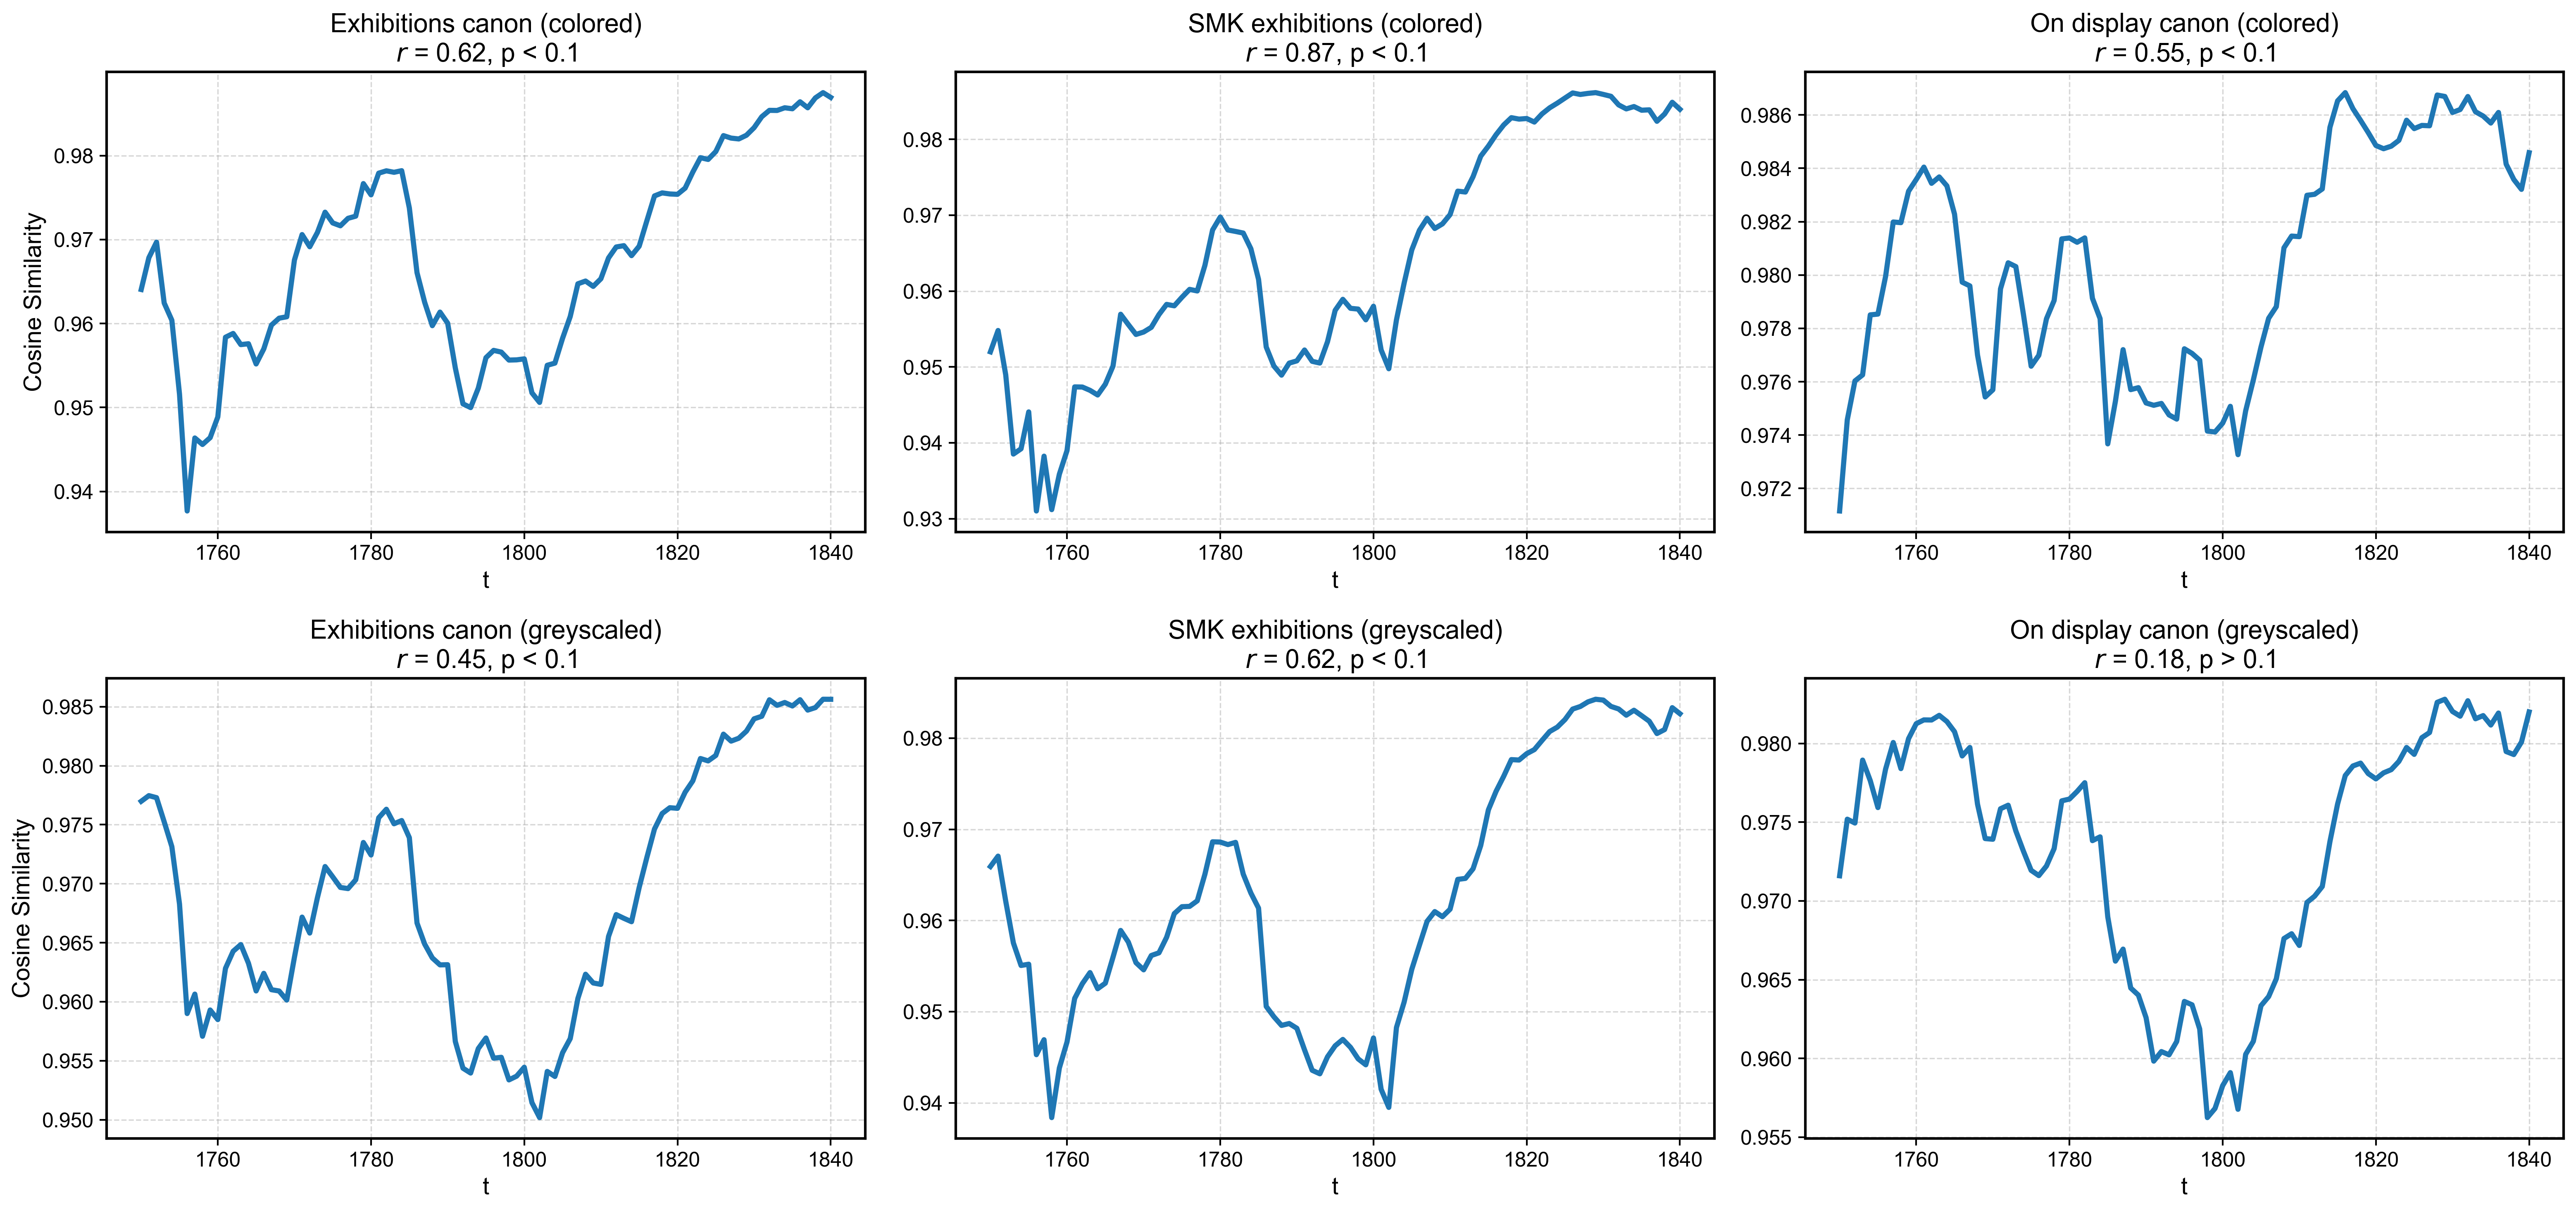

In [61]:
# inter

plot_grid(df = df, 
            color_subset = color_subset, 
            canon_cols = canon_cols,
        w_size= 30, 
            cosim_to_plot='CANON_NONCANON_COSIM', 
            title='',
            savefig=False,
            filename=os.path.join('figs', f'inter_w30.png'))

In [97]:
# pca 

def pca_binary(ax, df, embedding, canon_category, title):
    
    embeddings_array = np.array(df[embedding].to_list(), dtype=np.float32)
    
    color_mapping = {'other': '#129525', 'canon': '#75BCC6'}
    label_mapping = {'other': 'Non-canon', 'canon': 'Canon'}

    # to 2 dimensions
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(embeddings_array)
    df_pca = pd.DataFrame(pca_results, columns=["PCA1", "PCA2"])
    df_pca["canon"] = df[canon_category].values

    # Plot each category
    for category in df_pca["canon"].unique():
        subset = df_pca[df_pca["canon"] == category]

        #marker = markers_dict.get(category) 
        #alpha = alpha_dict.get(category)
        
        ax.scatter(
            subset["PCA1"],
            subset["PCA2"],
            color=color_mapping.get(category),
            label=label_mapping.get(category),
            alpha=0.6,
            edgecolor='black',
            s=110,
            marker='o' #marker
        )

    #for spine in ax.spines.values():
        #spine.set_linewidth(1.5)

    #for spine in ax.spines.values():
        #spine.set_visible(False)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("PCA1", fontsize=8)
    ax.set_ylabel("PCA2", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(True, linestyle='--', alpha=0.2)

    legend_handles = [Patch(facecolor=color_mapping[key], label=label_mapping[key]) for key in color_mapping]
    ax.legend(handles=legend_handles, loc='upper right', fontsize=8)

    ax.axis("equal")

    # supress warnings 

    np.seterr(divide='ignore', invalid='ignore')

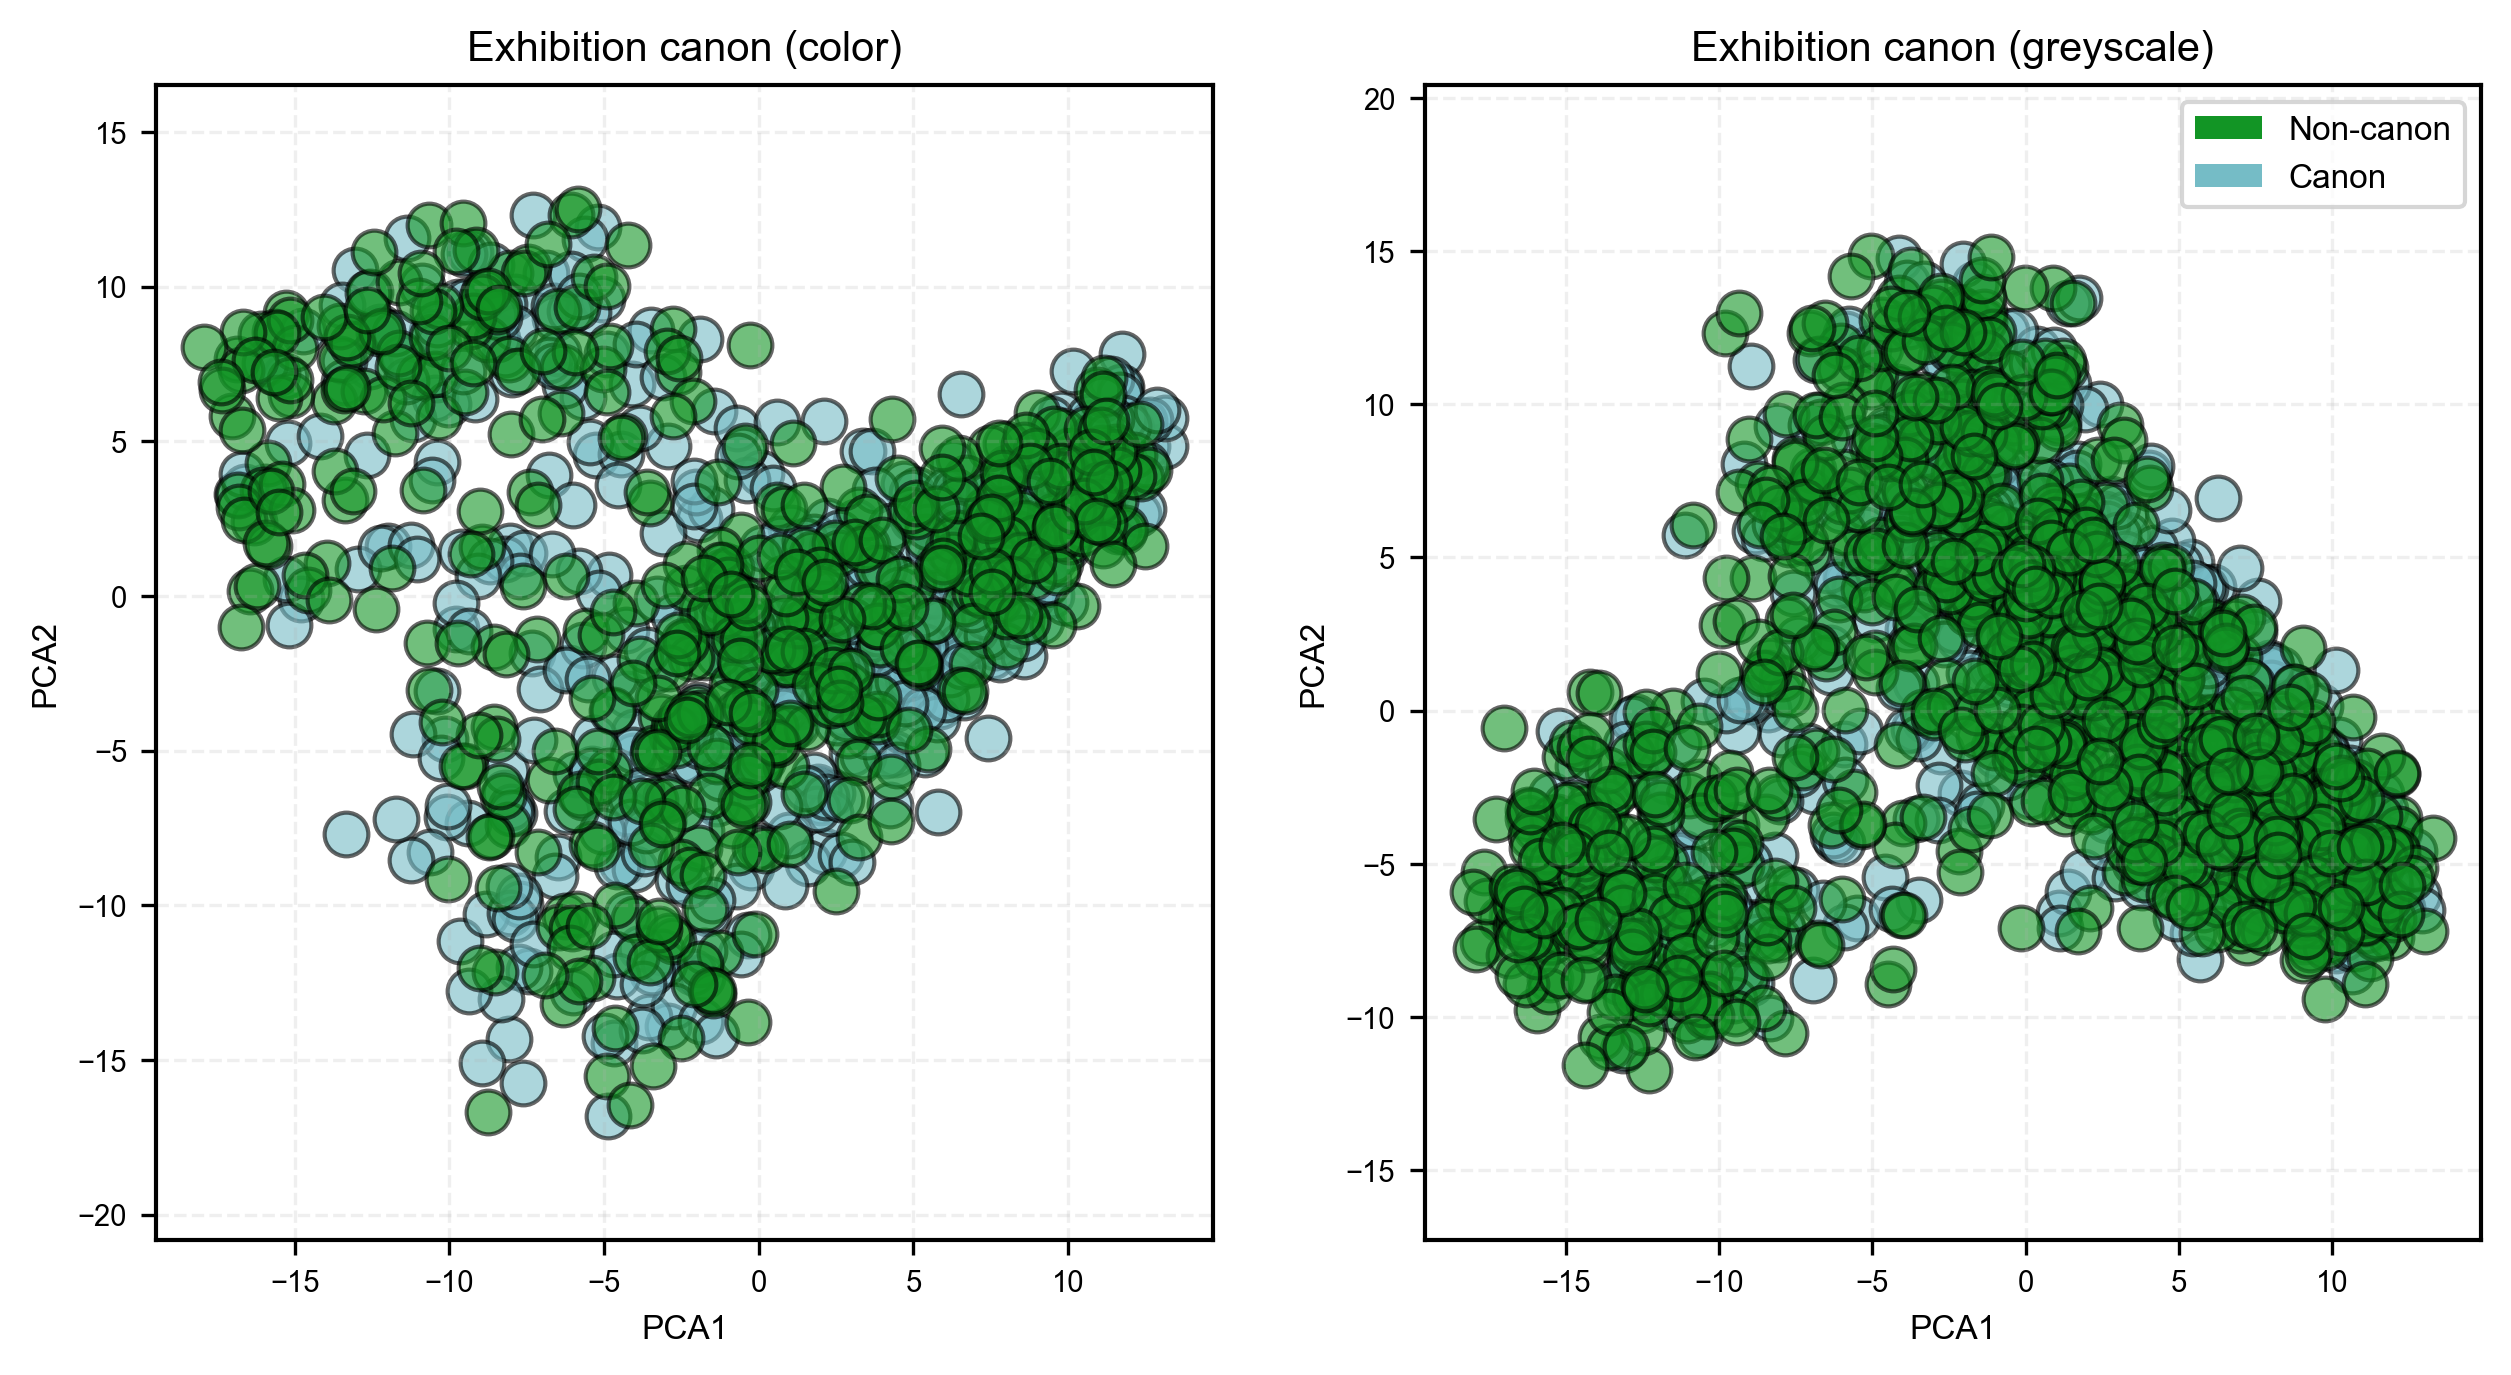

In [99]:
# plot pca_binary, greyscale and color embeddings
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

pca_binary(ax = axs[0], 
            df = color_subset, 
            embedding = 'embedding', 
            canon_category = 'exb_canon', 
            title = "Exhibition canon (color)")

axs[0].legend_.remove()

pca_binary(ax = axs[1], 
    df = df, 
    embedding = 'grey_embedding', 
    canon_category = 'exb_canon', 
    title = f"Exhibition canon (greyscale)")